# Eddy statistics in-shore to the southern Agulhas Current

This notebook is a part of the Ocean Training Course 2023, Working Group 2. It's main goal is to count _events_ (eddy merging, eddy dipoles) occuring in the area studied and sampled during the cruise.  


### User options

In [1]:
# I/O options
obs_datadir = {'MY' : r'../../observations/SEALEVEL_GLO_PHY_L4_MY_008_047/adt/', 
               'NRT': r'../../observations/SEALEVEL_GLO_PHY_L4_NRT_OBSERVATIONS_008_046/adt/'
              }

# Box definitions
box_south_agulhas = {'longitude': (26, 36), 'latitude': (-37, -32)}
box_semc          = {'longitude': (42.5, 47.5), 'latitude': (-28, -25)}

# Period of calculation
time_period  = ('2003-01-01', '2022-12-31')

# logger type
logger_type = 'ERROR'   # (py-eddy-tracker) Available options: ERROR, WARNING, INFO, DEBUG

In [2]:
# Constants
earth_radius = 6371229.

### Import necessary modules

In [3]:
import glob
import json
import os
import numpy as np
import xarray as xr

import cartopy.crs as ccrs
import cartopy.feature as cfeature

from datetime import datetime, timedelta
from matplotlib import colors as mcolors
from matplotlib import pyplot as plt
from matplotlib.path import Path
from shapely.geometry.polygon import LinearRing

from py_eddy_tracker import start_logger
from py_eddy_tracker.dataset.grid import RegularGridDataset
from py_eddy_tracker.featured_tracking.area_tracker import AreaTracker
from py_eddy_tracker.poly import create_vertice
from py_eddy_tracker.tracking import Correspondances

start_logger().setLevel(logger_type)

### function definition

In [4]:
def to_datetime(days):
    """convert a number of days after 1950-01-01 to the equivalent datetime"""
    
    return datetime(1950, 1, 1) + days * timedelta(days=1)


def select_obsfiles(lfiles, period=(None, None)):
    """select files corresponding to observation contain in a specified period."""
    rlist = list()
    
    for f in lfiles:
        if 'Cyclonic' in f:
            y = f.split('Cyclonic_')[-1][:4]
            m = f.split('Cyclonic_')[-1][4:6]
            d = f.split('Cyclonic_')[-1][6:8]
        elif 'Anticyclonic' in f:
            y = f.split('Anticyclonic_')[-1][:4]
            m = f.split('Anticyclonic_')[-1][4:6]
            d = f.split('Anticyclonic_')[-1][6:8]
        else:
            pass
        
        conds = period[0] is None or np.datetime64(y+'-'+m+'-'+d) >= np.datetime64(period[0])
        conds = conds and (period[1] is None or np.datetime64(y+'-'+m+'-'+d) <= np.datetime64(period[1]))
        if conds:
            rlist.append(f)
    
    return rlist

def select_tracks_in_box(eddies, box, min_lifetime=7):
    """select observations which are in a given lon, lat box."""
    lon_min, lon_max = box['longitude']
    lat_min, lat_max = box['latitude']
    
    track_ids, track_cnts = np.unique(eddies.tracks, return_counts=True)

    indexes_sel = np.where(track_cnts >= min_lifetime)[0]
    tracked_sel = eddies.extract_ids(list(track_ids[indexes_sel]))

    conds = (tracked_sel.lon >= lon_min) & (tracked_sel.lon <= lon_max)
    conds = conds & (tracked_sel.lat >= lat_min) & (tracked_sel.lat <= lat_max)

    ids_res = np.unique(tracked_sel.tracks[np.where(conds)[0]])
    obs_res = eddies.extract_ids(list(ids_res))
    
    return obs_res


def linear_ring_from_box(box):
    """return a LinearRing polygon object from a given box to plot in maps"""
    lon_min, lon_max = box['longitude']
    lat_min, lat_max = box['latitude']
    
    return LinearRing([(lon_min, lat_min), 
                       (lon_max, lat_min), 
                       (lon_max, lat_max), 
                       (lon_min, lat_max)])



## South Eastern Agulhas Current (SEAC) - some eddy statistics

In [5]:
# First, select all the eddy observations in the selected period 
cycl_files = list()
acyc_files = list()

for ptype in obs_datadir:
    cycl_files += glob.glob(os.path.join(obs_datadir[ptype], 'Cyclonic_*'))
    acyc_files += glob.glob(os.path.join(obs_datadir[ptype], 'Anticyclonic_*'))
    
cycl_files = sorted(select_obsfiles(cycl_files, period=time_period))
acyc_files = sorted(select_obsfiles(acyc_files, period=time_period))

In [6]:
# First, select the cyclonic eddies track (before and after merging)
c = Correspondances(datasets=sorted(cycl_files[:]), class_method=AreaTracker, virtual=3)
c.track()
c.prepare_merging()

a = Correspondances(datasets=sorted(acyc_files[:]), class_method=AreaTracker, virtual=3)
a.track()
a.prepare_merging()

# -- here, we get a collection of cyclonic eddies
c_eddies = c.merge(raw_data=False)
c_eddies.virtual[:] = c_eddies.time == 0
c_eddies.filled_by_interpolation(c_eddies.virtual == 1.)

# -- same for the anticyclonic eddies
a_eddies = a.merge(raw_data=False)
a_eddies.virtual[:] = a_eddies.time == 0
a_eddies.filled_by_interpolation(a_eddies.virtual == 1.)

### Generation/dissipation sites 

In [7]:
lon_min_sac, lon_max_sac = box_south_agulhas['longitude']
lat_min_sac, lat_max_sac = box_south_agulhas['latitude']

lon_min_semc, lon_max_semc = box_semc['longitude']
lat_min_semc, lat_max_semc = box_semc['latitude']

In [19]:
c_eddies_sac  = select_tracks_in_box(c_eddies, box_south_agulhas, min_lifetime=7)
ids_south_ac  = np.unique(c_eddies_sac.tracks)

c_formations  = {'south_ac': list(), 'semc': list(), 'retroflection': list()}
c_dissipation = {'south_ac': list(), 'semc': list(), 'retroflection': list()}

for id_c in ids_south_ac:
    track = c_eddies_sac.extract_ids([id_c])
    
    # check generation sites
    if (lon_min_sac <= track.lon[0] <= lon_max_sac) and (lat_min_sac <= track.lat[0] <= lat_max_sac):
        c_formations['south_ac'].append(id_c)
    
    elif (lon_min_semc <= track.lon[0] <= lon_max_semc) and (lat_min_semc <= track.lat[0] <= lat_max_semc):
        c_formations['semc'].append(id_c)
    
    elif (-43 <= track.lat[0] <= lat_min_sac):
        c_formations['retroflection'].append(id_c)
    
    # check dissipation sites
    if (lon_min_sac <= track.lon[-1] <= lon_max_sac) and (lat_min_sac <= track.lat[-1] <= lat_max_sac):
        c_dissipation['south_ac'].append(id_c)
    
    elif (lon_min_semc <= track.lon[-1] <= lon_max_semc) and (lat_min_semc <= track.lat[-1] <= lat_max_semc):
        c_dissipation['semc'].append(id_c)
    
    elif (-43 <= track.lat[-1] <= lat_min_sac):
        c_dissipation['retroflection'].append(id_c)


# Print generation/dissipation sites
print("Cyclonic eddies observed in the southern Agulhas Current region from {} to {}".format(*time_period))
print("  > Total: {} tracks on {} observations".format(len(ids_south_ac), len(c_eddies_sac.amplitude)))

nb_sac   = len(c_formations['south_ac'])
nb_semc  = len(c_formations['semc'])
nb_retro = len(c_formations['retroflection'])
nb_other = len(ids_south_ac) - nb_sac - nb_semc - nb_retro

print("  > generation sites:")
print("       South-East Agulhas Current   : {} ({:.1f}%)".format(nb_sac, 100*nb_sac/len(ids_south_ac)) )
print("       South-East Madagascar Current: {} ({:.1f}%)".format(nb_semc, 100*nb_semc/len(ids_south_ac)) )
print("       Agulhas retroflection area   : {} ({:.1f}%)".format(nb_retro, 100*nb_retro/len(ids_south_ac)) )
print("       Other areas                  : {} ({:.1f}%)".format(nb_other, 100*nb_other/len(ids_south_ac)) )

nb_sac   = len(c_dissipation['south_ac'])
nb_semc  = len(c_dissipation['semc'])
nb_retro = len(c_dissipation['retroflection'])
nb_other = len(ids_south_ac) - nb_sac - nb_semc - nb_retro

print("  > dissipation sites:")
print("       South-East Agulhas Current   : {} ({:.1f}%)".format(nb_sac, 100*nb_sac/len(ids_south_ac)) )
print("       South-East Madagascar Current: {} ({:.1f}%)".format(nb_semc, 100*nb_semc/len(ids_south_ac)) )
print("       Agulhas retroflection area   : {} ({:.1f}%)".format(nb_retro, 100*nb_retro/len(ids_south_ac)) )
print("       Other areas                  : {} ({:.1f}%)".format(nb_other, 100*nb_other/len(ids_south_ac)) )

Cyclonic eddies observed in the southern Agulhas Current region from 2003-01-01 to 2022-12-31
  > Total: 1527 tracks on 63369 observations
  > generation sites:
       South-East Agulhas Current   : 1122 (73.5%)
       South-East Madagascar Current: 42 (2.8%)
       Agulhas retroflection area   : 90 (5.9%)
       Other areas                  : 273 (17.9%)
  > dissipation sites:
       South-East Agulhas Current   : 1366 (89.5%)
       South-East Madagascar Current: 0 (0.0%)
       Agulhas retroflection area   : 94 (6.2%)
       Other areas                  : 67 (4.4%)


In [20]:
a_eddies_sac  = select_tracks_in_box(a_eddies, box_south_agulhas, min_lifetime=7)
ids_south_ac  = np.unique(a_eddies_sac.tracks)

a_formations  = {'south_ac': list(), 'semc': list(), 'retroflection': list()}
a_dissipation = {'south_ac': list(), 'semc': list(), 'retroflection': list()}

for id_a in ids_south_ac:
    track = a_eddies_sac.extract_ids([id_a])
    
    # check generation sites
    if (lon_min_sac <= track.lon[0] <= lon_max_sac) and (lat_min_sac <= track.lat[0] <= lat_max_sac):
        a_formations['south_ac'].append(id_a)
    
    elif (lon_min_semc <= track.lon[0] <= lon_max_semc) and (lat_min_semc <= track.lat[0] <= lat_max_semc):
        a_formations['semc'].append(id_a)
    
    elif (-43 <= track.lat[0] <= lat_min_sac):
        a_formations['retroflection'].append(id_a)
        
    # check dissipation sites
    if (lon_min_sac <= track.lon[-1] <= lon_max_sac) and (lat_min_sac <= track.lat[-1] <= lat_max_sac):
        a_dissipation['south_ac'].append(id_c)
    
    elif (lon_min_semc <= track.lon[-1] <= lon_max_semc) and (lat_min_semc <= track.lat[-1] <= lat_max_semc):
        a_dissipation['semc'].append(id_c)
    
    elif (-43 <= track.lat[-1] <= lat_min_sac):
        a_dissipation['retroflection'].append(id_c)

    
# Print generation/dissipation sites
print("Anticyclonic eddies observed in the southern Agulhas Current region from {} to {}".format(*time_period))
print("  > Total: {} tracks on {} observations".format(len(ids_south_ac), len(a_eddies_sac.amplitude)))

nb_sac   = len(a_formations['south_ac'])
nb_semc  = len(a_formations['semc'])
nb_retro = len(a_formations['retroflection'])
nb_other = len(ids_south_ac) - nb_sac - nb_semc - nb_retro

print("  > generation sites:")
print("       South-East Agulhas Current   : {} ({:.1f}%)".format(nb_sac, 100*nb_sac/len(ids_south_ac)) )
print("       South-East Madagascar Current: {} ({:.1f}%)".format(nb_semc, 100*nb_semc/len(ids_south_ac)) )
print("       Agulhas retroflection area   : {} ({:.1f}%)".format(nb_retro, 100*nb_retro/len(ids_south_ac)) )
print("       Other areas                  : {} ({:.1f}%)".format(nb_other, 100*nb_other/len(ids_south_ac)) )

nb_sac   = len(a_dissipation['south_ac'])
nb_semc  = len(a_dissipation['semc'])
nb_retro = len(a_dissipation['retroflection'])
nb_other = len(ids_south_ac) - nb_sac - nb_semc - nb_retro

print("  > dissipation sites:")
print("       South-East Agulhas Current   : {} ({:.1f}%)".format(nb_sac, 100*nb_sac/len(ids_south_ac)) )
print("       South-East Madagascar Current: {} ({:.1f}%)".format(nb_semc, 100*nb_semc/len(ids_south_ac)) )
print("       Agulhas retroflection area   : {} ({:.1f}%)".format(nb_retro, 100*nb_retro/len(ids_south_ac)) )
print("       Other areas                  : {} ({:.1f}%)".format(nb_other, 100*nb_other/len(ids_south_ac)) )

Anticyclonic eddies observed in the southern Agulhas Current region from 2003-01-01 to 2022-12-31
  > Total: 2209 tracks on 49216 observations
  > generation sites:
       South-East Agulhas Current   : 1794 (81.2%)
       South-East Madagascar Current: 0 (0.0%)
       Agulhas retroflection area   : 90 (4.1%)
       Other areas                  : 325 (14.7%)
  > dissipation sites:
       South-East Agulhas Current   : 1969 (89.1%)
       South-East Madagascar Current: 0 (0.0%)
       Agulhas retroflection area   : 123 (5.6%)
       Other areas                  : 117 (5.3%)


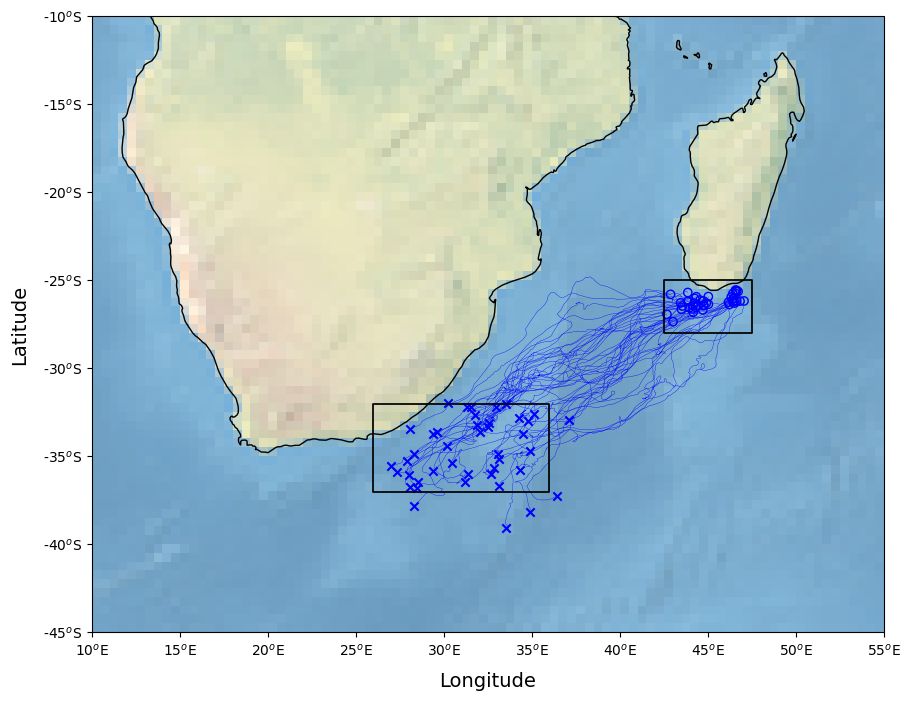

In [158]:
# Example visualize generation/dissipation sites of cyclonic eddies created in SEMC
# -- set `plot_track` to True to plot the track of each eddy
plot_track = True

gen_lons = list()
gen_lats = list()
dis_lons = list()
dis_lats = list()

ids_obs = c_formations['semc']

for ide in ids_obs:
    track = c_eddies_sac.extract_ids([ide])
    gen_lons.append(track.lon[0])
    gen_lats.append(track.lat[0])
    dis_lons.append(track.lon[-1])
    dis_lats.append(track.lat[-1])

# Plot generation/dissipation sites
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([10, 55, -45, -10], crs=ccrs.PlateCarree())

ax.set_xlabel(r"Longitude", size=14, labelpad=10)
ax.set_ylabel(r"Latitude",  size=14, labelpad=10)

# -- background image on for nice sea rendering
ax.stock_img()
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)

xticks = [10, 15, 20, 25, 30, 35, 40, 45, 50, 55]
yticks = [-45, -40, -35, -30, -25, -20, -15, -10]
ax.set_xticks(xticks)
ax.set_xticklabels(['{}$^o$E'.format(x) for x in xticks])
ax.set_yticks(yticks)
ax.set_yticklabels(['{}$^o$S'.format(y) for y in yticks])

# -- add eddy tracks
if plot_track:
    for ide in ids_obs:
        track = c_eddies_sac.extract_ids([ide])
        track.plot(ax, color="blue", lw=0.25)

# -- add eddy generation sites
ax.scatter(gen_lons, gen_lats, marker='o', facecolor='none', edgecolors='blue')
ax.scatter(dis_lons, dis_lats, marker='x', facecolor='blue')

# -- add contour box
geom_agulhas = linear_ring_from_box(box_south_agulhas)
geom_semc    = linear_ring_from_box(box_semc)

ax.add_geometries([geom_agulhas, geom_semc], ccrs.PlateCarree(), facecolor='none', edgecolor='k', lw=1.25, 
                  zorder=100)

plt.show()

fig.

### Characterize cyclonic and anticyclonic in the area

In [77]:
# Count and sort C/A eddy tracks by lifetime
eddy_lifetimes = np.concatenate( ([1], np.arange(7, 211, 7)) )
c_eddies_count = np.ones_like(eddy_lifetimes)*np.nan
a_eddies_count = np.ones_like(eddy_lifetimes)*np.nan
ca_ratio_count = np.ones_like(eddy_lifetimes)*np.nan

ac_eddies, ac_lifetime = np.unique(select_tracks_in_box(a_eddies, box_south_agulhas, min_lifetime=1).tracks, 
                                   return_counts=True)
ce_eddies, ce_lifetime = np.unique(select_tracks_in_box(c_eddies, box_south_agulhas, min_lifetime=1).tracks, 
                                   return_counts=True)

for i, days in enumerate(eddy_lifetimes):
    if (ce_lifetime > days).sum() != 0:
        c_eddies_count[i] = (ce_lifetime > days).sum()
    if (ac_lifetime > days).sum() != 0:
        a_eddies_count[i] = (ac_lifetime > days).sum()
        ca_ratio_count[i] = c_eddies_count[i]/a_eddies_count[i]

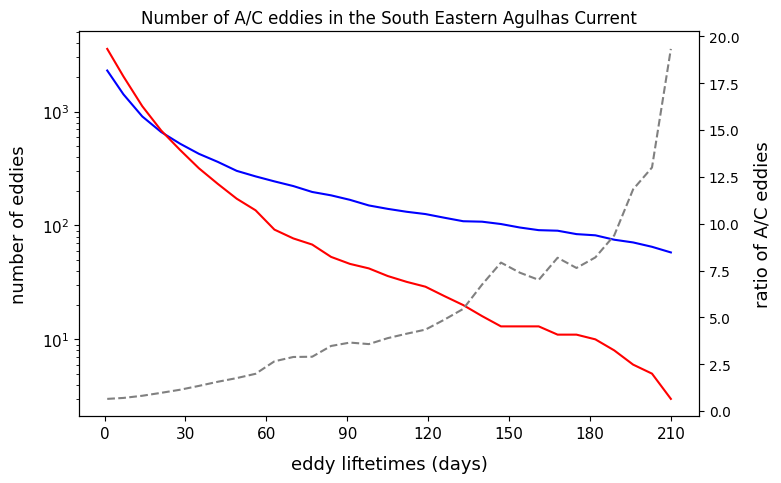

In [89]:
# Plot C/A eddy tracks repartition by lifetimes
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(1, 1, 1)

ax.set_title('Number of A/C eddies in the South Eastern Agulhas Current')
ax.set_xlabel('eddy liftetimes (days)', size=13, labelpad=10)
ax.set_ylabel('number of eddies',       size=13, labelpad=10)
ax.tick_params(labelsize=11)

ax.set_yscale('log')
ax.set_xticks(np.arange(0, 211, 30))
ax.plot(eddy_lifetimes, c_eddies_count, c='blue',  label='Cyclonic')
ax.plot(eddy_lifetimes, a_eddies_count, c='red',   label='Anticyclonic')

ax2 = ax.twinx()
ax2.set_ylabel('ratio of A/C eddies',  size=13, labelpad=10)
ax2.tick_params(labelsize=10)

ax2.plot(eddy_lifetimes, ca_ratio_count, c='grey', linestyle='dashed', label='Ration C/A')

fig.savefig('../../imgs/OTC23_number_eddies_by_lifetimes.png', dpi=300)

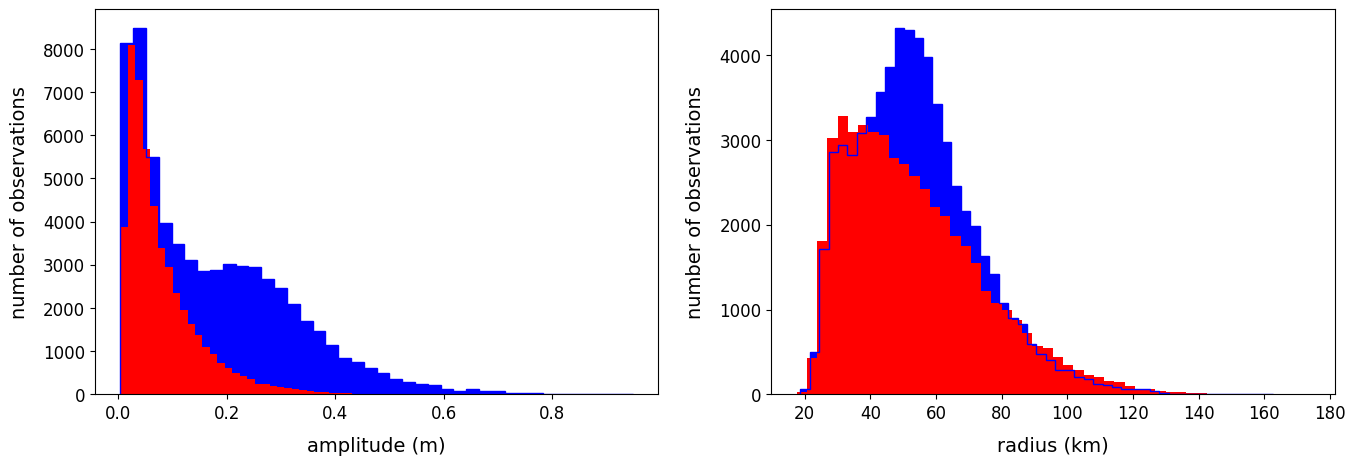

In [132]:
# Amplitude and radius histogram
fig = plt.figure(figsize=(16, 5))

# -- amplitude
ax = fig.add_subplot(1, 2, 1)
ax.set_xlabel('amplitude (m)', size=14, labelpad=10)
ax.set_ylabel('number of observations',  size=14, labelpad=10)
ax.tick_params(labelsize=12)

a_ampl = a_eddies_sac.amplitude
c_ampl = c_eddies_sac.amplitude

a_counts, a_bins = np.histogram(a_ampl, bins=40)
c_counts, c_bins = np.histogram(c_ampl, bins=40)

ax.stairs(c_counts, c_bins, color='blue', fill=True)
ax.stairs(a_counts, a_bins, color='red',  fill=True)
ax.stairs(c_counts, c_bins, color='blue', fill=False)

# -- radius
ax = fig.add_subplot(1, 2, 2)
ax.set_xlabel('radius (km)', size=14, labelpad=10)
ax.set_ylabel('number of observations',  size=14, labelpad=10)
ax.tick_params(labelsize=12)

a_radius = a_eddies_sac.speed_radius * 1e-3
c_radius = c_eddies_sac.speed_radius * 1e-3

a_counts, a_bins = np.histogram(a_radius, bins=50)
c_counts, c_bins = np.histogram(c_radius, bins=50)

ax.stairs(c_counts, c_bins, color='blue', fill=True)
ax.stairs(a_counts, a_bins, color='red',  fill=True)
ax.stairs(c_counts, c_bins, color='blue', fill=False)

fig.savefig('../../imgs/OTC23_eddies_amplitude_radius_frequency.png', dpi=300)